In [1]:
from tensorflow.keras.models import load_model

import numpy as np
from tensorflow.image import extract_patches
import rasterio
import tensorflow as tf

In [2]:
# List available physical devices and check for GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

if physical_devices:
    # Set memory growth to prevent memory allocation issues
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU detected. Using CPU.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
model_path="output/model/lstm_mul_model_eaton.h5"
model = load_model(model_path)
# sar_image_path="output/sar/3_eaton_s1_mul_ready.tif"

# model_path="output/model/lstm_model_eaton.h5"
# model = load_model(model_path)

# sar_image_path="../MachineLearning/input/eaton_s1_ready.tif"
# output_prediction_path="output/prediction/lstm_eaton.tif"

sar_image_path="output/sar/2_palisades_s1_mul_ready_clip.tif"
output_prediction_path="output/prediction/lstm_eaton_pred_palisade.tif"


2025-04-02 22:17:28.130912: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-02 22:17:28.130938: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-02 22:17:28.130946: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-02 22:17:28.131021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-02 22:17:28.131403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import numpy as np

def create_patch(data_set, patch_size=5):
    """
    Creates a patch for every pixel in the dataset.
    
    Parameters:
    data_set (numpy array): 3D NumPy array representing the dataset (rows, cols, bands).
    patch_size (int): Size of the square patch (default: 5).
    
    Returns:
    numpy array: 4D array of shape (rows * cols, patch_size, patch_size, bands).
    """
    rows, cols, bands = data_set.shape
    max_row, max_col = rows - 1, cols - 1
    
    # Initialize the output tensor
    input_tensor = np.zeros((rows * cols, patch_size, patch_size, bands))
    
    # Iterate over each pixel to create patches
    index = 0
    for row in range(rows):
        for col in range(cols):
            patch = np.zeros((patch_size, patch_size, bands))
            patch_top_row = row - patch_size // 2
            patch_left_col = col - patch_size // 2
            
            for i in range(patch_size):
                for j in range(patch_size):
                    patch_row = patch_top_row + i
                    patch_col = patch_left_col + j
                    
                    # Ensure the indices are within the valid range
                    if 0 <= patch_row <= max_row and 0 <= patch_col <= max_col:
                        patch[i, j, :] = data_set[patch_row, patch_col, :]
            
            input_tensor[index] = patch
            index += 1
    
    return input_tensor

In [5]:
with rasterio.open(sar_image_path) as dataset:
    data_set = dataset.read([1,2,3,4]) 
    data_set = np.transpose(data_set, (1, 2, 0))

In [6]:
width,height,_=data_set.shape

In [7]:

input_tensor=create_patch(data_set, patch_size=5)

In [8]:
predictions = model.predict(input_tensor)

2025-04-02 22:18:21.963495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-02 22:18:22.064338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-02 22:18:22.117772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-04-02 22:18:22.157113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


111352/111352 [==============================] - 343s 3ms/step


In [9]:
# predictions
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
predicted_map = predicted_labels.reshape(width, height)

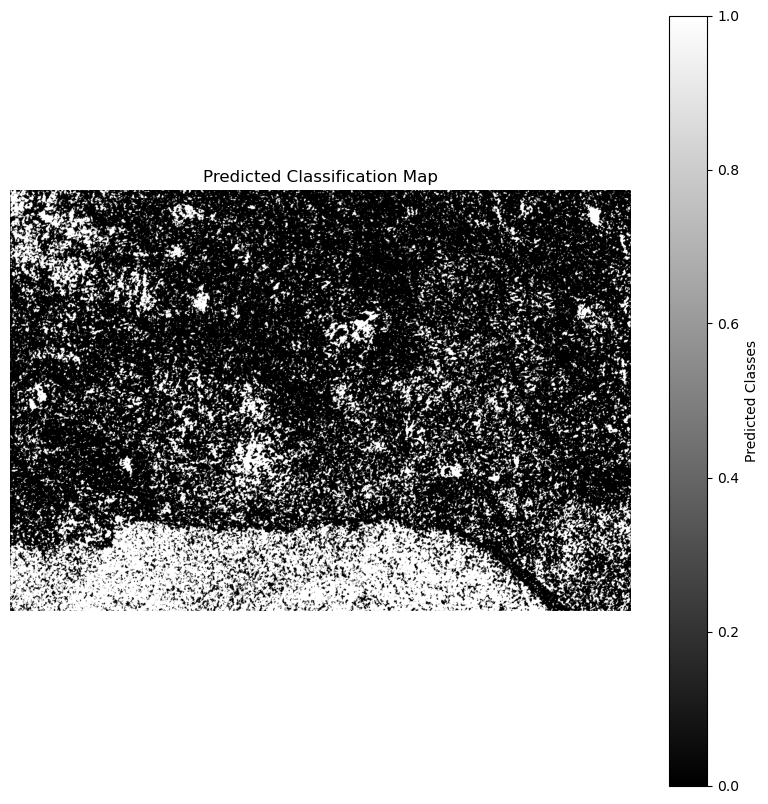

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(predicted_map, cmap='gray')  # Use a colormap that highlights classes
plt.colorbar(label="Predicted Classes")
plt.title("Predicted Classification Map")
plt.axis("off")
plt.show()


In [11]:
import tifffile as tiff
# Save as TIFF
tiff.imwrite(output_prediction_path, predicted_map.astype(np.float32))

/Users/rabinatwayana/Rabina/anaconda3/envs/wildfire_env/lib/python3.8/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


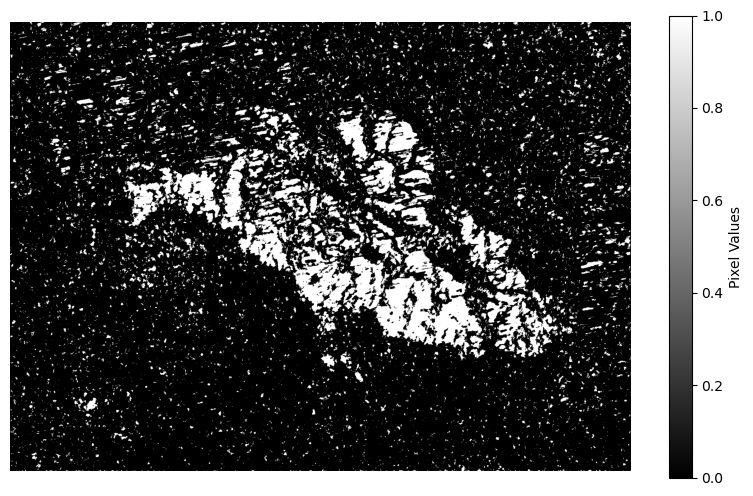

In [12]:
with rasterio.open("output/prediction/lstm_eaton_mul.tif") as src:
    image = src.read(1)  # Read the first band
    profile = src.profile  # Get metadata

    # Display image properties
    # print(f"TIFF Metadata for {os.path.basename(tiff_path)}:", profile)

    # Plot the first band
    plt.figure(figsize=(10, 6))
    plt.imshow(image, cmap="gray")  # Change cmap as needed
    plt.colorbar(label="Pixel Values")
    # plt.title(f"TIFF Image - {os.path.basename(tiff_path)}")
    plt.axis("off")
    plt.show()